# Gradient Boosting Classifier
I got XGBoost recommended to use as classifier, so let's see what it gives. Appearantly, more than half of the Kaggle competitions are won using this method. More explanation about Gradient boosting classifiers can be found [here](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook), [here](https://www.analyticsvidhya.com/blog/2016/01/gradient-boosting-algorithm-machine-learning/) or in [this paper](https://jerryfriedman.su.domains/ftp/trebst.pdf).
The sklearn documentation of the sklearn GradientBoostingClassifier can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). XGBoost itself has [it's own library](https://xgboost.readthedocs.io/en/stable/python/python_api.html).


In [2]:
import numpy as np

from util import get_wpm_train_test, fit_predict_print_wp, get_manually_labeled_features
from sklearn.ensemble import GradientBoostingClassifier

train_x_full, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=False)
train_x = get_manually_labeled_features(train_x_full)

model = GradientBoostingClassifier(random_state=42)

fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 53.30% (97/182)


The results are not better than the previousmodels, so let's immediately try xgboost to see if it can do better.

In [3]:
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 54.40% (98/182)


This gives a slight improvement, but still not better than our naïve bayes clssifier. Let's try some hyperparameters. I'll follow [this](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook) guide. While following the xgboost intuition explanation [here](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook), some sample parameteres where used in the article that I wanted to test, and they already gave better restults:


In [4]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100
}

model = XGBClassifier(random_state=42, **params)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y)

Accuracy: 56.59% (103/182)


In [5]:
from util import get_manually_labeled_features, predict_wp, evaluate_wp, get_winners_only
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {'max_depth': hp.quniform("max_depth", 2, 10, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 2000,  # 180 hp.quniform('n_estimators', 100, 5000, 1),
         'seed': 42
         }

group_kfold = GroupKFold(n_splits=2)

train_x.reset_index(drop=True, inplace=True)  # Not sure whether this is necessarily
train_x_full.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

train_index, test_index = next(group_kfold.split(train_x_full, train_y, groups=groups))
train_x_, train_y_ = train_x_full.iloc[train_index], train_y.iloc[train_index]
val_x, val_y = train_x_full.iloc[test_index], get_winners_only(train_y.iloc[test_index])

groups_val = train_x_['Test']
val_x.head()

,Test,Headline ID,Headline,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,1,A,Barack en Michelle Obama laten dansmoves zien ...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,B,Barack en Michelle Obama gaan helemaal los tij...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,4,A,Internethype 'uit rijdende auto springen en da...,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1
8,4,B,Levensgevaarlijke internethype waait over uit ...,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1
11,7,A,Brandweer wil man uit brand op zesde verdiepin...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
def objective(space):
    if 'max_depth' in space:
        space['max_depth'] = int(space['max_depth'])

    model = XGBClassifier(**space)

    feature_vecs = get_manually_labeled_features(train_x_)
    train_labels = train_y_['Winner']

    assert len(feature_vecs) == len(train_labels) == len(groups_val)

    model.fit(get_manually_labeled_features(train_x_), train_y_['Winner'], groups_val, sample_weight=None, verbose=0)

    predicted_winners = predict_wp(model, val_x)

    assert len(predicted_winners) == len(val_y)

    accuracy = evaluate_wp(val_y, predicted_winners)

    print(f"Accuracy: {accuracy} for parameters {space}")

    return {'loss': -accuracy, 'status': STATUS_OK}


trials = Trials()

# best_params = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)
# best_params

First output:
Accuracy: 0.6143250688705234 for parameters {'colsample_bytree': 0.6791708315892704, 'gamma': 1.6776735267349485, 'max_depth': 4.0, 'min_child_weight': 5.0, 'n_estimators': 2000, 'reg_alpha': 166.0, 'reg_lambda': 0.3143609826533077, 'seed': 42}
  1%|          | 1/100 [00:01<01:38,  1.01trial/s, best loss: -0.6143250688705234]

Last output:
Accuracy: 0.6143250688705234 for parameters {'colsample_bytree': 0.6719335050018236, 'gamma': 7.017770580747134, 'max_depth': 7.0, 'min_child_weight': 5.0, 'n_estimators': 2000, 'reg_alpha': 113.0, 'reg_lambda': 0.003552172716062952, 'seed': 42}
100%|██████████| 100/100 [01:29<00:00,  1.12trial/s, best loss: -0.6170798898071626]

{'colsample_bytree': 0.6500096592267572,
 'gamma': 7.558340556589674,
 'max_depth': 5.0,
 'min_child_weight': 10.0,
 'reg_alpha': 156.0,
 'reg_lambda': 0.4016083487002631}

The parameters itself don't seem to make a lot of difference.

In [7]:
best_params = {'colsample_bytree': 0.6500096592267572,
               'gamma': 7.558340556589674,
               'max_depth': 5,
               'min_child_weight': 10,
               'reg_alpha': 156,
               'reg_lambda': 0.4016083487002631}

model = XGBClassifier(n_estimators=100, random_state=42, **best_params)

fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=train_x_full['Test'])

Accuracy: 53.85% (98/182)


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Almost no improvement, even worse than the few parametrs we randomly tested. Maybe I'm targtting th wrong hyperparameters or using the wrong values. Let's take a look at all different parameters:

Let's focus on reg_alpha, reg_lambda, gamma, learning_rate and colsample_bytree.

In [8]:
space = {
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'n_estimators': 500,
}
trials = Trials()

# best_params = fmin(fn=objective,
#                    space=space,
#                    algo=tpe.suggest,
#                    max_evals=500,
#                    trials=trials)
# best_params

100%|██████████| 500/500 [04:07<00:00,  2.02trial/s, best loss: -0.6253443526170799]

{'colsample_bytree': 0.5012636742809072,
 'gamma': 2.865011368404072,
 'learning_rate': 0.010029562333387768,
 'max_depth': 2.0,
 'reg_alpha': 73.0,
 'reg_lambda': 0.6682379307006133}

In [9]:
best_params = {'colsample_bytree': 0.5012636742809072,
               'gamma': 2.865011368404072,
               'learning_rate': 0.010029562333387768,
               'max_depth': 2,
               'reg_alpha': 73.0,
               'reg_lambda': 0.6682379307006133}

In [10]:
model = XGBClassifier(n_estimators=500, random_state=42, **best_params)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=train_x_full['Test'])

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 53.30% (97/182)


Again a lot lower than the validation set, let's verify the score is actually calculated the same way:

In [11]:
model = XGBClassifier(n_estimators=500, random_state=42, **best_params)
fit_predict_print_wp(model, train_x_, train_y_, val_x, val_y, groups=groups_val)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 62.26% (226/363)


Hmm, seems like we're indeed overfitting on the validation set. Let's see whether the results are better when using our smaller train set (for with the validation set).

In [12]:
model = XGBClassifier(n_estimators=500, random_state=42, **best_params)
fit_predict_print_wp(model, train_x_, train_y_, test_x, test_y, groups=groups_val)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 53.30% (97/182)


The reduced number of samples in the train set doesn't seem to make any difference.
Solution to overfitting to the validation set is cross validation:

In [28]:
group_kfold = GroupKFold(n_splits=5)

train_x.reset_index(drop=True, inplace=True)  # Not sure whether this is necessarily
train_x_full.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)


def objective_cv(space):
    if 'max_depth' in space:
        space['max_depth'] = int(space['max_depth'])

    model = XGBClassifier(**space)

    accuracies = []
    for train_index, val_index in group_kfold.split(train_x, train_y, groups=train_x_full['Test']):

        train_x_small, train_y_small = train_x_full.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x_full.iloc[val_index], get_winners_only(train_y.iloc[val_index])
        # groups_val = train_x_full.iloc[val_index]['Test']

        model.fit(get_manually_labeled_features(train_x_small), train_y_small['Winner']) #, groups_val, sample_weight=None, verbose=0)

        predicted_winners = predict_wp(model, val_x)

        assert len(predicted_winners) == len(val_y)

        accuracy = evaluate_wp(val_y, predicted_winners)

        accuracies.append(accuracy)

    accuracy_mean = np.mean(accuracies)
    # print(f"Accuracy mean: {accuracy_mean} for parameters {space}")

    return {'loss': -accuracy_mean, 'status': STATUS_OK}

In [29]:
space = {
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'n_estimators': 500,
}
trials = Trials()

best_params = fmin(fn=objective_cv,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=500,
                   trials=trials)
best_params

100%|██████████| 500/500 [15:21<00:00,  1.84s/trial, best loss: -0.5633349078885215]


{'colsample_bytree': 0.8376842762481432,
 'gamma': 1.0100982566020316,
 'learning_rate': 0.10560571568287097,
 'max_depth': 5.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.46191366472424383}

100%|██████████| 500/500 [15:21<00:00,  1.84s/trial, best loss: -0.5633349078885215]

{'colsample_bytree': 0.8376842762481432,
 'gamma': 1.0100982566020316,
 'learning_rate': 0.10560571568287097,
 'max_depth': 5.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.46191366472424383}

In [34]:
best_params = {'colsample_bytree': 0.8376842762481432,
               'gamma': 1.0100982566020316,
               'learning_rate': 0.10560571568287097,
               'max_depth': 5,
               'reg_alpha': 41.0,
               'reg_lambda': 0.46191366472424383}


In [36]:
model = XGBClassifier(n_estimators=500, random_state=42, **best_params)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=train_x_full['Test'])

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 51.65% (94/182)


## Feature importance

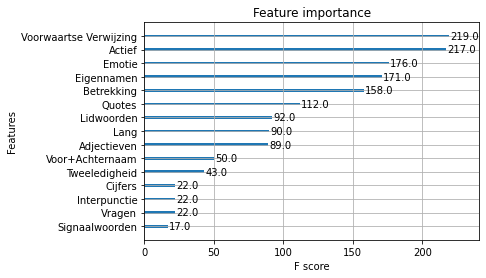

<Figure size 1152x864 with 0 Axes>

In [14]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.figure(figsize=(16, 12))
plt.show()